# Single-model ensemble modeling for flu challenge

In [1]:
import torch
import pandas as pd
from collections import defaultdict
from typing import Dict, List, Callable

import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.result_processing import cdc_format

### Collect models and data

In [2]:
fl_models = ["seirh_Florida.json", "fl_age_model.json", "fl_seirhd.json"]
fl_data = "data_fl.csv"

pa_models = ["seirh_Pennsylvania.json", "pa_age_model.json", "pa_seirhd.json"]
pa_data = "data_pa.csv"

### Set parameters for sampling. 

Note that the time unit is weeks.

In [3]:
start_time = 0.0 # October 14, 2024
end_data = 8.0 # December 9, 2023
end_time = 12.0 # forecast to January 6, 2024
logging_step_size = 1.0
num_samples = 100

# FLORIDA

## Ensemble

### Set up callable solution mappings

In [4]:
def create_solution_mapping(mapping: Dict[str, str]) -> Callable[[Dict[str, torch.Tensor]], Dict[str, torch.Tensor]]:
    def solution_mapping(individual_states: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        ensemble_map = {}
        for state, value in individual_states.items():
            if state in mapping:
                ensemble_map[mapping[state]] = value
        return ensemble_map
    return solution_mapping

# Mappings
solution_mappings_dicts = [
    {'cumulative_hosp': 'cumulative_hosp'},
    {'cumulative_hosp': 'cumulative_hosp'},
    {'cumulative_hosp': 'cumulative_hosp'}
]

# Convert each dictionary to a callable function
solution_mappings = [create_solution_mapping(mapping) for mapping in solution_mappings_dicts]


### Calibrate ensemble of a single model, and plot the results

Data printout: This dataset contains 8 rows of data. The first column, Timestamp, begins at 0.0 and ends at 8.0. The subsequent columns are named: cumulative_hosp


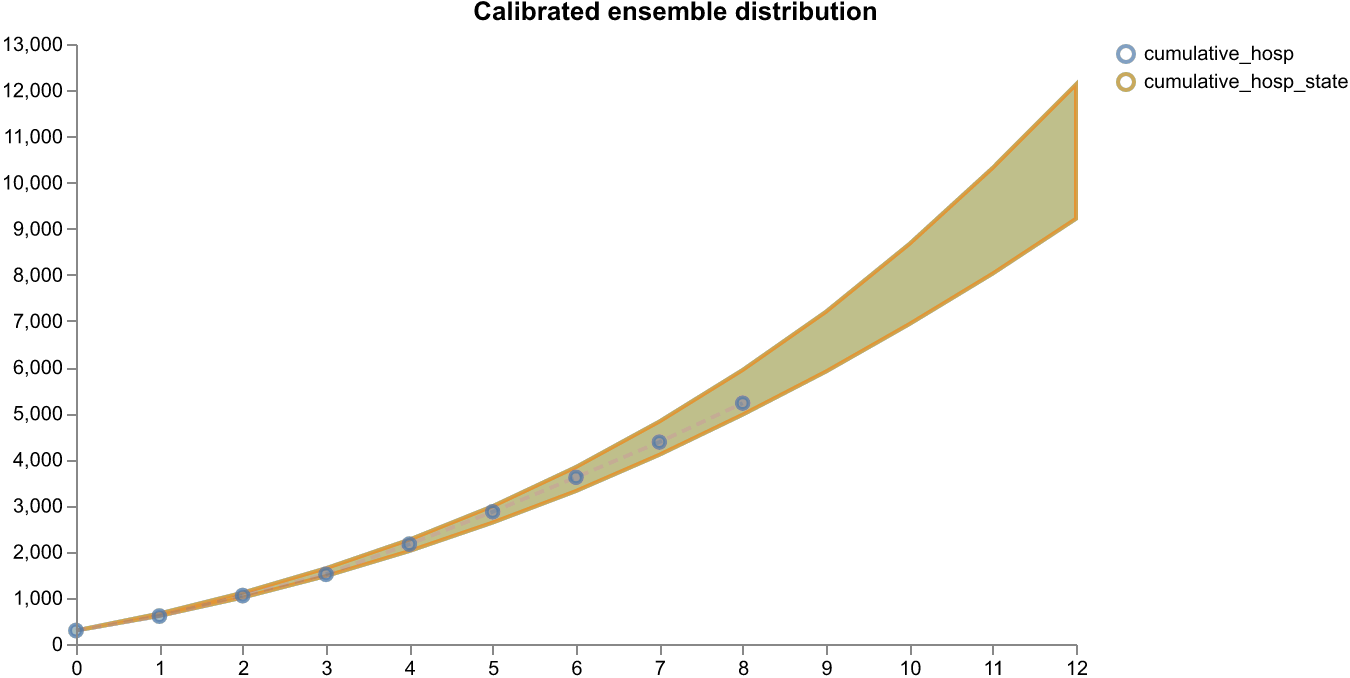

In [11]:
dataset = pd.read_csv(fl_data).drop(columns=['Timestamp']).reset_index(drop=True)
data_mapping = {'cumulative_hosp': 'cumulative_hosp'}
num_iterations = 250

calibrated_results = pyciemss.ensemble_calibrate(
    [fl_models[0]], 
    [solution_mappings[0]], 
    fl_data, 
    data_mapping=data_mapping, 
    num_iterations=num_iterations
)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

num_samples = 500
calibrated_ensemble_result = pyciemss.ensemble_sample(
    [fl_models[0]], 
    [solution_mappings[0]], 
    end_time, 
    logging_step_size, 
    num_samples, 
    start_time=start_time, 
    inferred_parameters=parameter_estimates,
    time_unit="weeks"
)
# display(calibrated_ensemble_result['data'].head())

# Plot the result
schema = plots.trajectories(
    calibrated_ensemble_result["data"], 
    keep="cumulative_hosp_state", 
    points=dataset.reset_index(drop=True),
    title=[f"Calibrated ensemble distribution"]
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Reformatting ensemble results

In [12]:
# display(calibrated_ensemble_result["ensemble_quantiles"])
calibrated_ensemble_result["ensemble_quantiles"].rename(columns={"number_weeks": "number_days"}, inplace=True)
# display(calibrated_ensemble_result["ensemble_quantiles"])

q_ensemble_data = cdc_format(
    calibrated_ensemble_result["ensemble_quantiles"],
    time_unit="days",
    solution_string_mapping={
        "incident_hosp": "weekly hosp admissions",
    },
    forecast_start_date="2023-12-09",
    location="Florida",
    drop_column_names=[
        "timepoint_id",
        "number_days",
        "output",
    ],
    train_end_point=8.0,
)
print("CDC Format:")
display(q_ensemble_data)

CDC Format:


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:344: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


type  quantile        value                               target  \
4094  quantile     0.010   859.488643  1.0 days ahead  incident_hosp_state   
4095  quantile     0.025   887.955457  1.0 days ahead  incident_hosp_state   
4096  quantile     0.050   928.915552  1.0 days ahead  incident_hosp_state   
4097  quantile     0.100   961.376025  1.0 days ahead  incident_hosp_state   
4098  quantile     0.150   993.651343  1.0 days ahead  incident_hosp_state   
...        ...       ...          ...                                  ...   
4181  quantile     0.850  1639.380127  4.0 days ahead  incident_hosp_state   
4182  quantile     0.900  1675.971875  4.0 days ahead  incident_hosp_state   
4183  quantile     0.950  1761.345117  4.0 days ahead  incident_hosp_state   
4184  quantile     0.975  1838.474316  4.0 days ahead  incident_hosp_state   
4185  quantile     0.990  1868.228926  4.0 days ahead  incident_hosp_state   

     forecast_date target_end_date location  
4094    2023-12-09      2023-12-10  Florida  
4095    2023-12-09      2023-12-10  Florida  
4096    2023-12-09      2023-12-10  Florida  
4097    2023-12-09      2023-12-10  Florida  
4098    2023-12-09      2023-12-10  Florida  
...            ...             ...      ...  
4181    2023-12-09      2023-12-13  Florida  
4182    2023-12-09      2023-12-13  Florida  
4183    2023-12-09      2023-12-13  Florida  
4184    2023-12-09      2023-12-13  Florida  
4185    2023-12-09      2023-12-13  Florida  

[92 rows x 7 columns]

### Adjusting output to be in terms of weeks, not days

In [13]:
df = q_ensemble_data

# Change target column 
df['target'] = df['target'].str.replace('days', 'week(s)')
df['target'] = df['target'].str.replace('incident_hosp_state', 'inc hosp')

# Change forecast dates
date_mappings = {
    "2023-12-10": "2023-12-16",
    "2023-12-11": "2023-12-23",
    "2023-12-12": "2023-12-30",
    "2023-12-13": "2024-01-06"
}

df['target_end_date'] = df['target_end_date'].replace(date_mappings)

# Save ensemble results
# print(df)
df.to_csv('Florida_single_flu_ensemble_results.csv', index=False)

# PENNSYLVANIA

### Calibrate the ensemble model and plot the results

Data printout: This dataset contains 8 rows of data. The first column, Timestamp, begins at 0.0 and ends at 8.0. The subsequent columns are named: cumulative_hosp


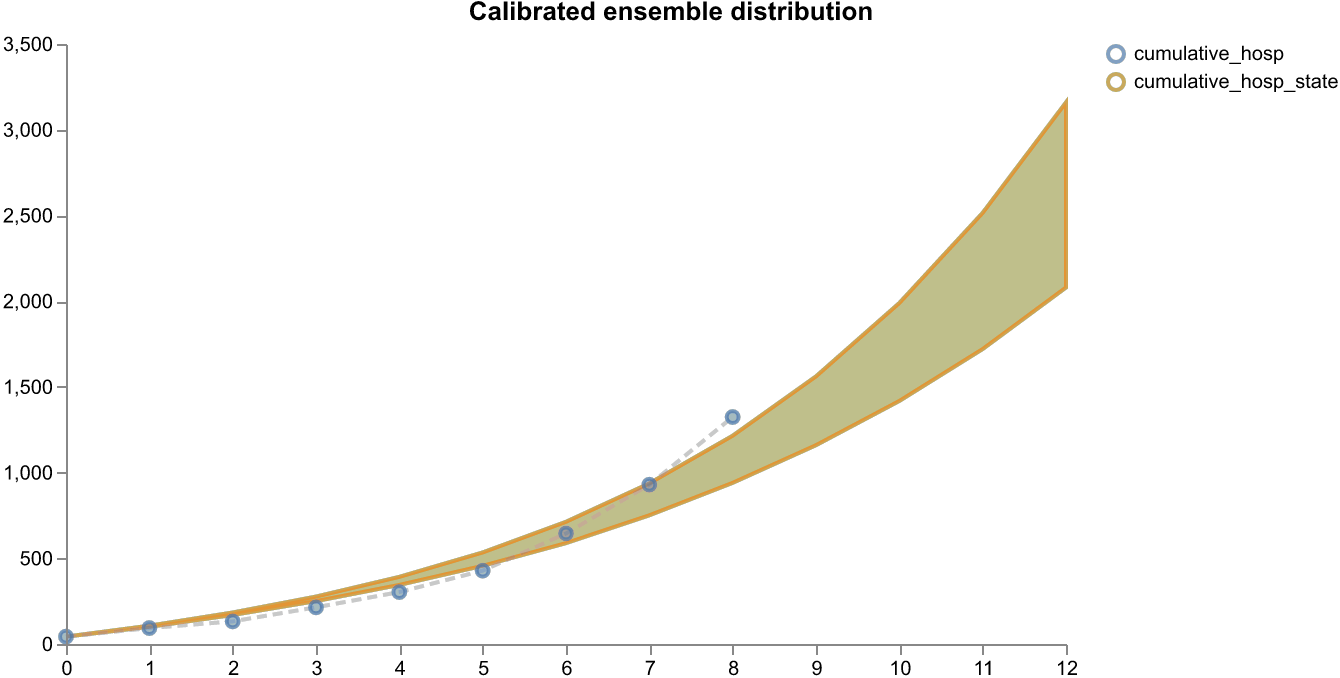

In [7]:
dataset = pd.read_csv(pa_data).drop(columns=['Timestamp']).reset_index(drop=True)
data_mapping = {'cumulative_hosp': 'cumulative_hosp'}
num_iterations = 250

calibrated_results = pyciemss.ensemble_calibrate(
    [pa_models[1]], 
    [solution_mappings[1]], 
    pa_data, 
    data_mapping=data_mapping, 
    num_iterations=num_iterations
)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

num_samples = 500
calibrated_ensemble_result = pyciemss.ensemble_sample(
    [pa_models[1]], 
    [solution_mappings[1]], 
    end_time, 
    logging_step_size, 
    num_samples, 
    start_time=start_time, 
    inferred_parameters=parameter_estimates,
    time_unit="weeks"
)
# display(calibrated_ensemble_result['data'].head())

# Plot the result
schema = plots.trajectories(
    calibrated_ensemble_result["data"], 
    keep="cumulative_hosp_state", 
    points=dataset.reset_index(drop=True),
    title=[f"Calibrated ensemble distribution"]
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Reformatting ensemble results

In [8]:
# display(calibrated_ensemble_result["ensemble_quantiles"])
calibrated_ensemble_result["ensemble_quantiles"].rename(columns={"number_weeks": "number_days"}, inplace=True)
# display(calibrated_ensemble_result["ensemble_quantiles"])

q_ensemble_data = cdc_format(
    calibrated_ensemble_result["ensemble_quantiles"],
    time_unit="days",
    solution_string_mapping={
        "incident_hosp": "weekly hosp admissions",
    },
    forecast_start_date="2023-12-09",
    location="Pennsylvania",
    drop_column_names=[
        "timepoint_id",
        "number_days",
        "output",
    ],
    train_end_point=8.0,
)
print("CDC Format:")
display(q_ensemble_data)

CDC Format:


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:344: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


type  quantile       value                               target  \
8280  quantile     0.010  197.869829  1.0 days ahead  incident_hosp_state   
8281  quantile     0.025  207.899251  1.0 days ahead  incident_hosp_state   
8282  quantile     0.050  220.466544  1.0 days ahead  incident_hosp_state   
8283  quantile     0.100  232.644757  1.0 days ahead  incident_hosp_state   
8284  quantile     0.150  238.895560  1.0 days ahead  incident_hosp_state   
...        ...       ...         ...                                  ...   
8367  quantile     0.850  578.420679  4.0 days ahead  incident_hosp_state   
8368  quantile     0.900  606.136548  4.0 days ahead  incident_hosp_state   
8369  quantile     0.950  644.938306  4.0 days ahead  incident_hosp_state   
8370  quantile     0.975  676.682074  4.0 days ahead  incident_hosp_state   
8371  quantile     0.990  705.950913  4.0 days ahead  incident_hosp_state   

     forecast_date target_end_date      location  
8280    2023-12-09      2023-12-10  Pennsylvania  
8281    2023-12-09      2023-12-10  Pennsylvania  
8282    2023-12-09      2023-12-10  Pennsylvania  
8283    2023-12-09      2023-12-10  Pennsylvania  
8284    2023-12-09      2023-12-10  Pennsylvania  
...            ...             ...           ...  
8367    2023-12-09      2023-12-13  Pennsylvania  
8368    2023-12-09      2023-12-13  Pennsylvania  
8369    2023-12-09      2023-12-13  Pennsylvania  
8370    2023-12-09      2023-12-13  Pennsylvania  
8371    2023-12-09      2023-12-13  Pennsylvania  

[92 rows x 7 columns]

### Adjusting output to be in terms of weeks, not days

In [10]:
df = q_ensemble_data

# Change target column and forecast dates
df['target'] = df['target'].str.replace('days', 'week(s)')
df['target'] = df['target'].str.replace('incident_hosp_state', 'inc hosp')

date_mappings = {
    "2023-12-10": "2023-12-16",
    "2023-12-11": "2023-12-23",
    "2023-12-12": "2023-12-30",
    "2023-12-13": "2024-01-06"
}
df['target_end_date'] = df['target_end_date'].replace(date_mappings)

# Save ensemble results
# print(df)
df.to_csv('Pennsylvania_single_flu_ensemble_results.csv', index=False)